In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import string
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["font.size"] = 16

SAVE_FIGURES = True

if SAVE_FIGURES:
    os.makedirs(os.path.join(os.pardir, "images"), exist_ok=True)

In [2]:
from superscreen import version_table

version_table()

## Code Block 1

In [3]:
from superscreen import Parameter

def f(x, y, a=1, b=0):
    return a * x**2 + b * y
    
param = Parameter(f, a=0, b=1)
print(param) # Parameter<f(a=0, b=1)>

other_param = Parameter(f, a=2, b=3)
print(other_param) # Parameter<f(a=2, b=3)>

print(param(0, 0) == f(0, 0, a=0, b=1)) # True
print(other_param(1, 2) == f(1, 2, a=2, b=3)) # True

param_squared = param ** 2
print(param_squared) # CompositeParameter<(f(a=0, b=1) ** 2)>

print(param_squared(3, 4) == f(3, 4, a=0, b=1) ** 2) # True
print(
    (5 * param_squared / other_param)(5, 6)
    == 5 * f(5, 6, a=0, b=1) ** 2 / f(5, 6, a=2, b=3)
) # True

Parameter<f(a=0, b=1)>
Parameter<f(a=2, b=3)>
True
True
CompositeParameter<(f(a=0, b=1) ** 2)>
True
True


## Code Block 2

In [4]:
import superscreen as sc
import superscreen.geometry as geo

def make_ring(
    inner_radius=2.5,
    outer_radius=5,
    inner_points=200,
    outer_points=400,
    Lambda=1,
    square=False,
):
    if square:
        outer = geo.square(2 * outer_radius, points_per_side=outer_points // 4)
        inner = geo.square(2 * inner_radius, points_per_side=inner_points // 4)
        bbox = geo.square(1.25 * 2 * outer_radius, points_per_side=10)
    else:
        outer = geo.circle(outer_radius, points=outer_points)
        inner = geo.circle(inner_radius, points=inner_points)
        bbox = geo.circle(1.25 * outer_radius, points=40)
    layers = [sc.Layer("base", Lambda=Lambda, z0=0)]
    films = [sc.Polygon("ring", layer="base", points=outer)]
    holes = [sc.Polygon("hole", layer="base", points=inner)]
    abstract_regions = [sc.Polygon("bbox", layer="base", points=bbox)]
    return sc.Device(
        "ring",
        layers=layers,
        films=films,
        holes=holes,
        abstract_regions=abstract_regions,
        length_units="um",
    )

## Code Block 3 & Figure 1

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Finished generating mesh with 5114 points and 10066 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.
INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 10066 triangles.
INFO:superscreen.device:Finished generating mesh with 5114 points and 10066 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.
INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Finished generating mesh with 5199 points and 10199 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.
INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing me

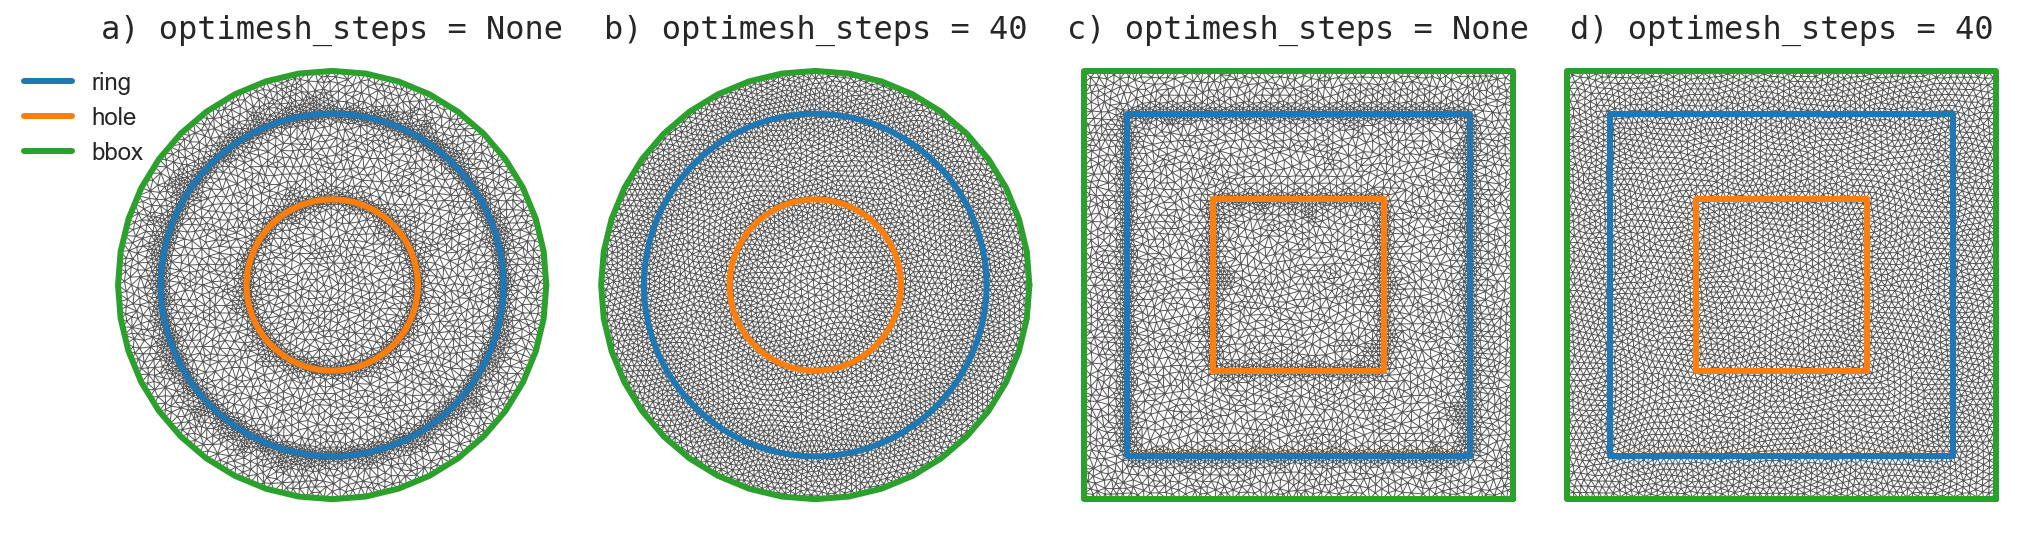

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(14, 4), facecolor="w", constrained_layout=True)
axlist = list(axes.flat)
# Create the Devices
ring = make_ring(square=False)
square_ring = make_ring(square=True)
# min_triangles specifies the minimum number of mesh elements.
min_triangles = 10000
# optimesh_steps specifies the the number of iterations of
# optimesh optimization to perform.
# Set optimesh_steps=None to disable optimesh optimization.
optimesh_steps = (None, 40)
# For more meshing options, see the docstring for Device.make_mesh().
for row, device in zip(axes.reshape(2, 2), (ring, square_ring)):
    for ax, opt_steps in zip(row, optimesh_steps):
        # Generate and visualize the mesh
        device.make_mesh(min_triangles=min_triangles, optimesh_steps=opt_steps)
        device.plot_polygons(
            ax=ax,
            linewidth=3,
            legend=False,
            plot_mesh=True,
            mesh_kwargs=dict(color="k", alpha=0.65, linewidth=0.5),
        )
        label = string.ascii_lowercase[axlist.index(ax)]
        title = f"{label}) optimesh_steps = {opt_steps}"
        ax.set_title(title, fontsize=16, fontfamily="monospace")
        ax.axis("off")
axlist[0].legend(bbox_to_anchor=(-0.2, 1), loc="upper left", fontsize=12)

if SAVE_FIGURES:
    fig.savefig("../images/mesh.pdf", bbox_inches="tight")

INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.


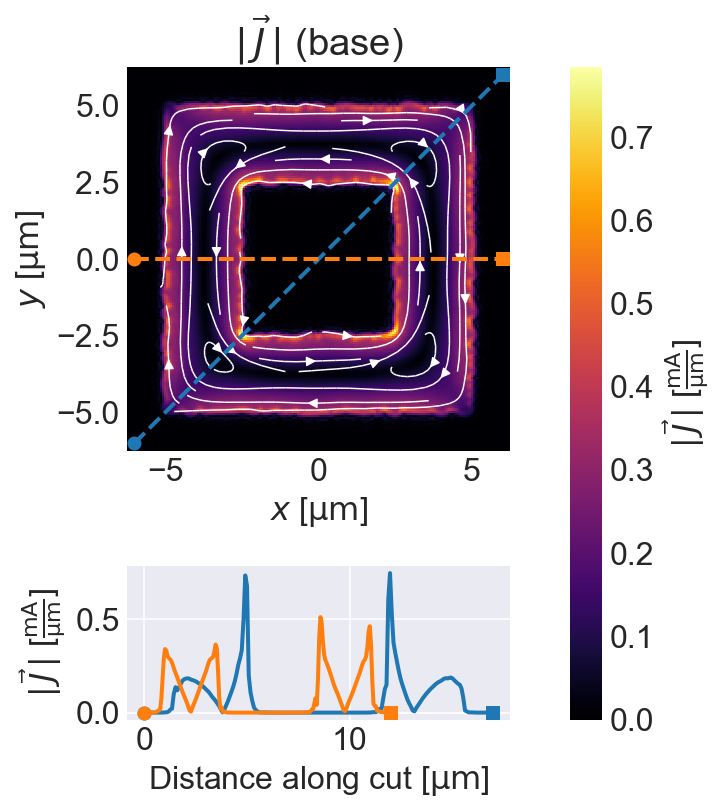

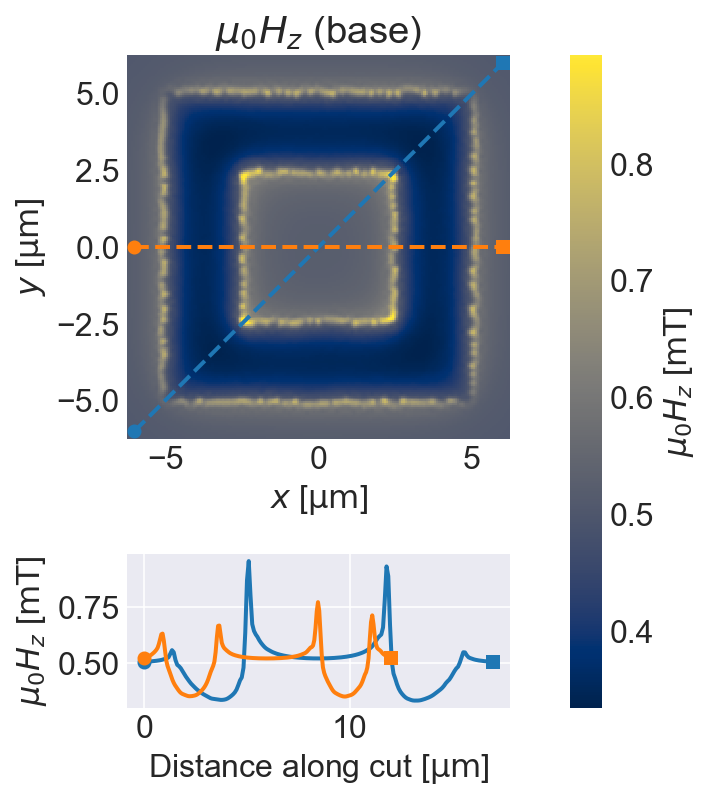

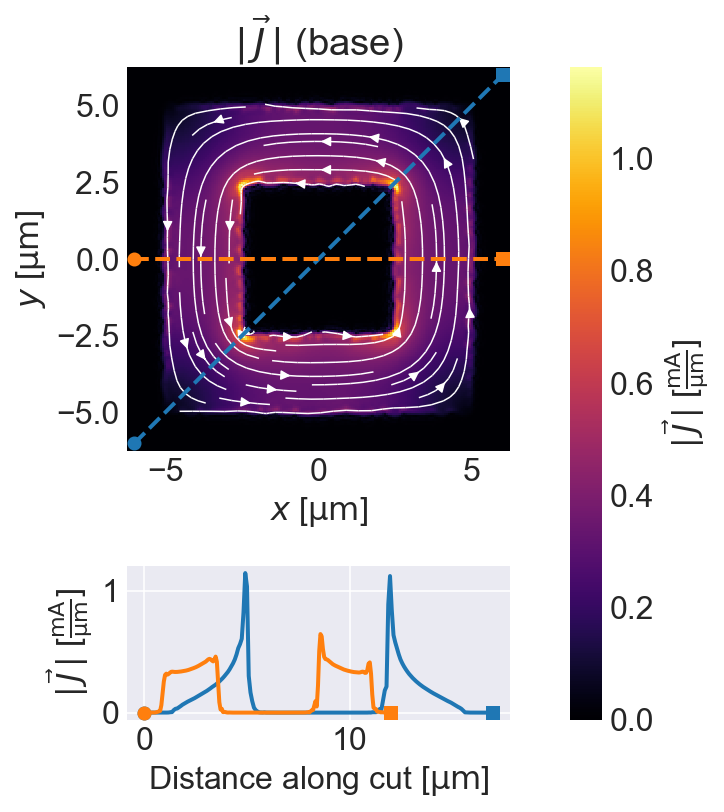

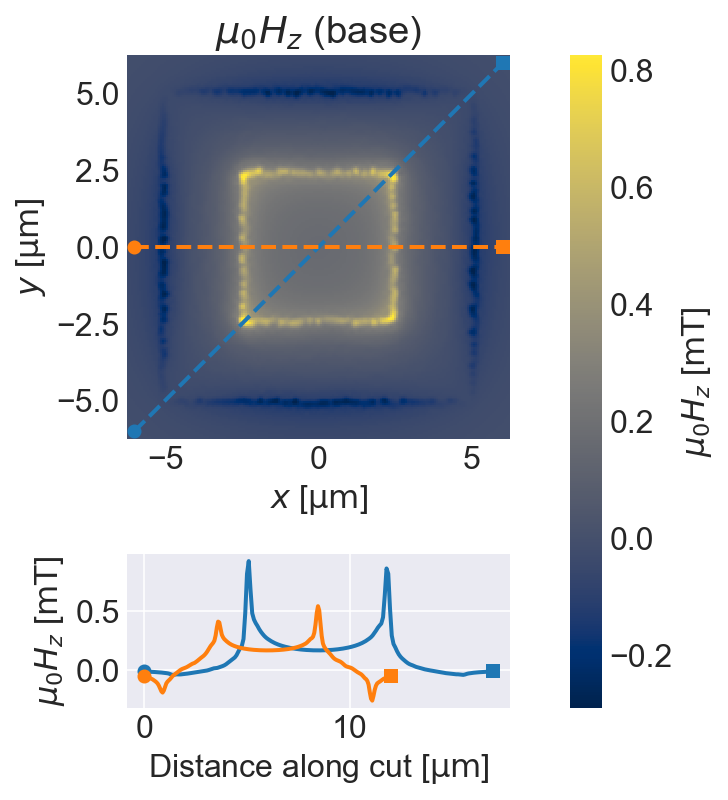

In [6]:
# Simulate the response to a uniform applied field of 0.5 mT
applied_field = sc.sources.ConstantField(0.5)
field_units = "mT"

solutions = sc.solve(
    device=square_ring,
    applied_field=applied_field,
    field_units=field_units,
)
assert len(solutions) == 1 # Since there is only one layer
uniform_field = solutions[-1]

# Simulate a current circulating around the hole in the ring.
circulating_currents = {"hole": "1 mA"}

solutions = sc.solve(
    device=square_ring,
    applied_field=None,
    circulating_currents=circulating_currents
)
assert len(solutions) == 1 # Since there is only one layer
trapped_flux = solutions[-1]

xs = np.linspace(-6, 6, 201)
cross_sections = [
    np.stack([xs, xs], axis=1),
    np.stack([xs, 0 * xs], axis=1),
]

filenames = []
for solution, label in zip((uniform_field, trapped_flux), ("screening", "trapped_flux")):
    fig_j, axes_j = solution.plot_currents(
        figsize=(5, 6),
        cross_section_coords=cross_sections,
        units="mA/um",
    )
    fig_h, axes_h = solution.plot_fields(
        figsize=(5, 6),
        cross_section_coords=cross_sections,
        auto_range_cutoff=0.05,
    )
    if SAVE_FIGURES:
        fig_j.savefig(f"../images/{label}_current.png", dpi=600, bbox_inches="tight")
        fig_h.savefig(f"../images/{label}_field.png", dpi=600, bbox_inches="tight")
        filenames.append(f"../images/{label}_current.png")
        filenames.append(f"../images/{label}_field.png")

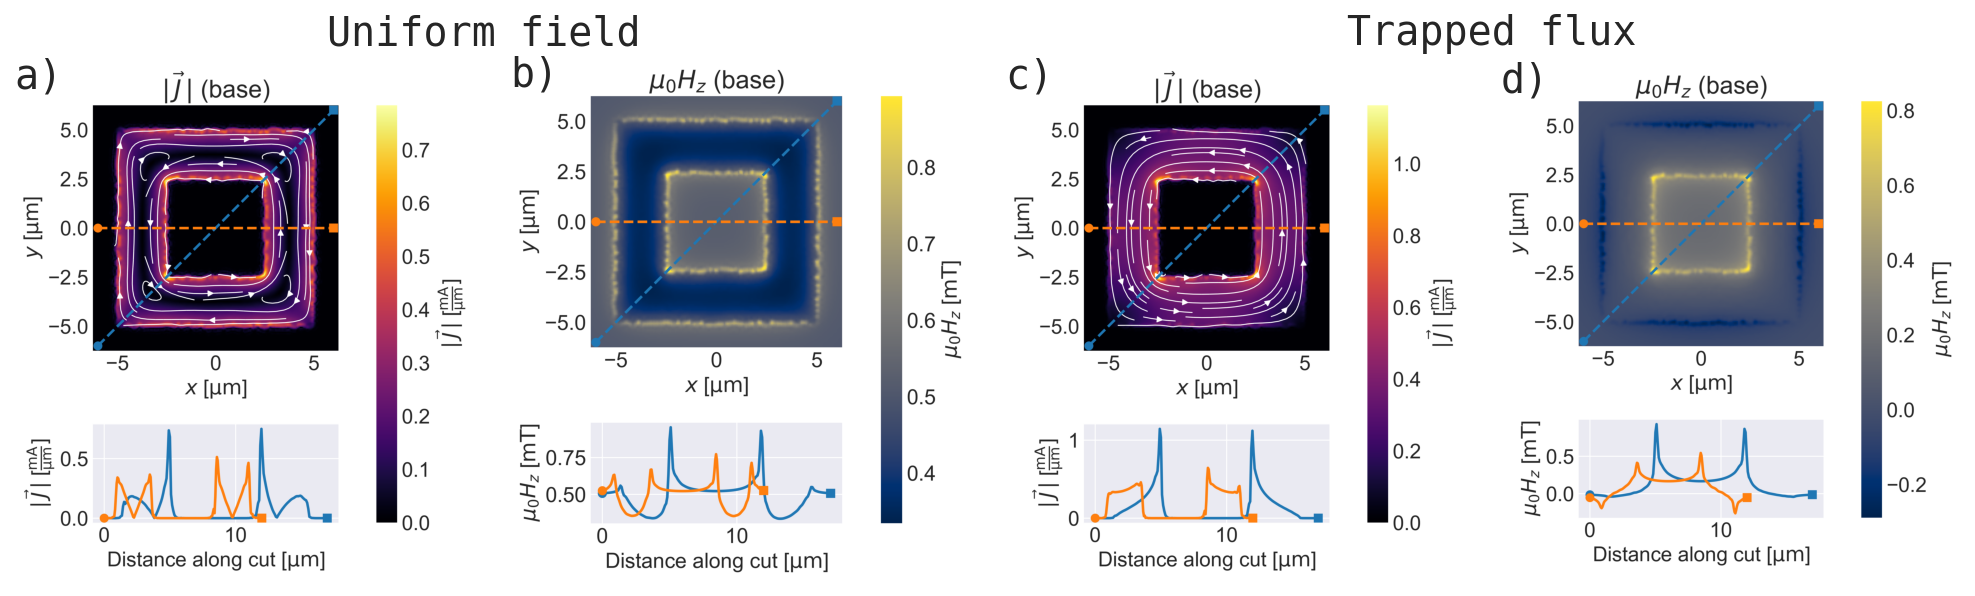

In [7]:
if SAVE_FIGURES:
    fig, axes = plt.subplots(1, 4, figsize=(14, 6), facecolor="w")
    for ax, fname, label in zip(axes.flat, filenames, string.ascii_lowercase):
        ax.imshow(plt.imread(fname))
        ax.axis("off")
        ax.text(0, 0.95, label + ")", transform=ax.transAxes, size=20, family="monospace")
    for text, x0 in [("Uniform field", 0.25), ("Trapped flux", 0.75)]:
        fig.text(x0, 1, text, size=20, family="monospace", ha="center", va="top")
    fig.tight_layout()
    fig.subplots_adjust(top=1.25)
    fig.savefig("../images/square_ring_results.png", dpi=600, bbox_inches="tight")

## Example: Mutual inductance between two rings

In [8]:
length_units = "um"
inner_radius = 2.5
outer_radius = 5

layers = [
    sc.Layer("layer0", Lambda=1, z0=0),
    sc.Layer("layer1", Lambda=1, z0=1),
]

films = [
    sc.Polygon("square_ring", layer="layer0", points=geo.square(1.5 * outer_radius, points_per_side=50)),
    sc.Polygon("round_ring", layer="layer1", points=geo.circle(outer_radius, points=200)),
]

holes = [
    sc.Polygon("square_hole", layer="layer0", points=geo.square(1 * inner_radius, points_per_side=50)),
    sc.Polygon("round_hole", layer="layer1", points=geo.circle(inner_radius, points=100)),
]

abstract_regions = [
    sc.Polygon("bbox", layer="layer0", points=geo.square(1.25 * 2 * outer_radius, points_per_side=10))
]

device = sc.Device(
    "two_rings",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units
)

In [9]:
device.make_mesh(min_triangles=10000, optimesh_steps=40)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 10263 triangles.
INFO:superscreen.device:Finished generating mesh with 5231 points and 10263 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


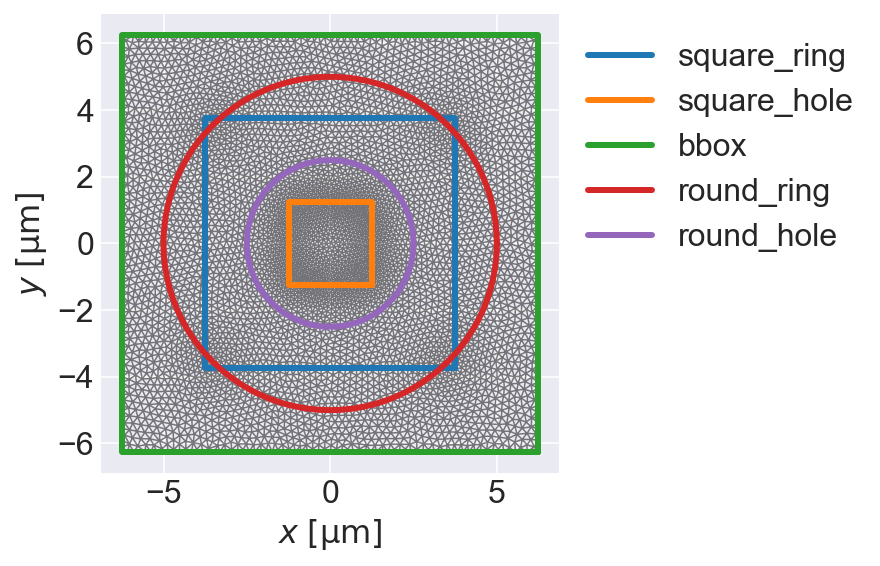

In [10]:
ax = device.plot_polygons(
    linewidth=3, plot_mesh=True, mesh_kwargs=dict(color="k", alpha=0.5, linewidth=0.75),
)

In [11]:
hole_polygon_mapping = {
    "square_hole": sc.geometry.square(6, points_per_side=51),
    "round_hole": sc.geometry.circle(4, points=201),
}
hole_polygon_mapping = None

M = device.mutual_inductance_matrix(hole_polygon_mapping, iterations=3)

INFO:superscreen.solve:Calculating layer0 response to applied field.
INFO:superscreen.solve:Calculating layer1 response to applied field.
INFO:superscreen.solve:Caching 1 layer-to-layer kernel(s) (410 MB total) in memory.
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (1/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (1/3).
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (2/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (2/3).
INFO:superscreen.solve:Calculating layer0 response to applied field and screening field from other layers (3/3).
INFO:superscreen.solve:Calculating layer1 response to applied field and screening field from other layers (3/3).
INFO:superscreen.solve:Calculating layer0 response to applied field.
INFO:superscreen.solve:Calculat

In [12]:
M

array([[12.1831509 ,  3.10053188],
       [ 3.101789  , 18.83825001]]) <Unit('picohenry')>

## Appendix - Fluxoid

In [13]:
def as_si(x, ndp):
    s = "{x:0.{ndp:d}e}".format(x=x, ndp=ndp)
    m, e = s.split("e")
    return "{m:s}\\times 10^{{{e:d}}}".format(m=m, e=int(e))

def plot_polygons(
    solution, polygons, figsize=(5, 4), axes_off=True, show_device_polygons=True
):
    fig_j, (ax_j,) = solution.plot_currents(
        figsize=figsize, streamplot=False, units="mA / um",
    )
    fig_h, (ax_h,) = solution.plot_fields(figsize=figsize, auto_range_cutoff=0.05)

    for i, polygon in enumerate(polygons):
        ax_j.plot(*polygon.T, f"C{i}-", lw=3)
        ax_h.plot(*polygon.T, f"C{i}-", lw=3)
    if axes_off:
        ax_j.axis("off")
        ax_h.axis("off")
    if show_device_polygons:
        for ax, color in zip((ax_j, ax_h), ("w", "w")):
            solution.device.plot_polygons(
                ax=ax, legend=False, color=color, ls="-", lw=1,
            )
    return (fig_j, ax_j), (fig_h, ax_h)

def plot_fluxoids(
    solution,
    polygons,
    linewidth=3,
    invert_supercurrent_part=False,
    figsize=(8, 4),
):
    sign = -1 if invert_supercurrent_part else 1
    lw = linewidth
    fig, ax = plt.subplots(figsize=figsize, facecolor="w")
    width = 0.3

    fluxoids = []
    for i, polygon in enumerate(polygons):
        print(i, end=" ")
        fluxoid = solution.polygon_fluxoid(
            polygon, flux_units="Phi_0", with_units=False,
        )["base"]
        fluxoids.append(fluxoid)
        ax.bar(
            i - width / 2,
            fluxoid.flux_part,
            fc=f"C{i}",
            ec=f"C{i}",
            lw=lw,
            width=width,
        )
        ax.bar(
            i + width / 2,
            sign * fluxoid.supercurrent_part,
            fill=False,
            ec=f"C{i}",
            lw=lw,
            width=width,
        )
        ax.bar(
            i,
            sum(fluxoid),
            ec="k",
            fill=False,
            lw=lw,
            ls="--",
            zorder=12,
            width=2 * width,
        )

    if invert_supercurrent_part:
        label = "$-1\\times$ Supercurrent part"
    else:
        label = "Supercurrent part"  
    ax.bar(-1, 0, fc="k", ec="k", lw=lw, label="Flux part")
    ax.bar(-1, 0, fill=False, ec="k", lw=lw, label=label)
    ax.bar(-1, 0, fill=False, ec="k", ls="--", lw=lw, label="Total fluxoid")

    ax.set_xlim(-0.5, len(polygons) - 0.5)
    ax.set_xticks(range(len(polygons)))
    for i, label in enumerate(ax.xaxis.get_ticklabels()):
        label.set_color(f"C{i}")

    ax.set_xlabel("Polygon $S$")
    ax.set_ylabel("Fluxoid $\\Phi^f_S$ [$\\Phi_0$]")
    ax.legend(bbox_to_anchor=(1, 1), fancybox=True, shadow=True)
    
    return fig, ax, fluxoids

In [14]:
fluxoid_fnames = {}

In [15]:
polygons = [
    sc.geometry.ellipse(0.75, 4, center=(-3.75, 0.25), points=401),
    sc.geometry.ellipse(0.75, 1.25, center=(3.5, 3.25), points=301, angle=45),
    sc.geometry.ellipse(4, 0.75, points=401, center=(0, -3.75)),
    sc.geometry.rectangle(1.5, 3, center=(3.75, -2), x_points=101),
    sc.geometry.rectangle(4, 1.25, center=(-2.25, 3.5), x_points=101),
]
polygons = [sc.geometry.close_curve(p) for p in polygons]

### Simply-connected regions

INFO:superscreen.solve:Calculating base response to applied field.


0 1 2 3 4 

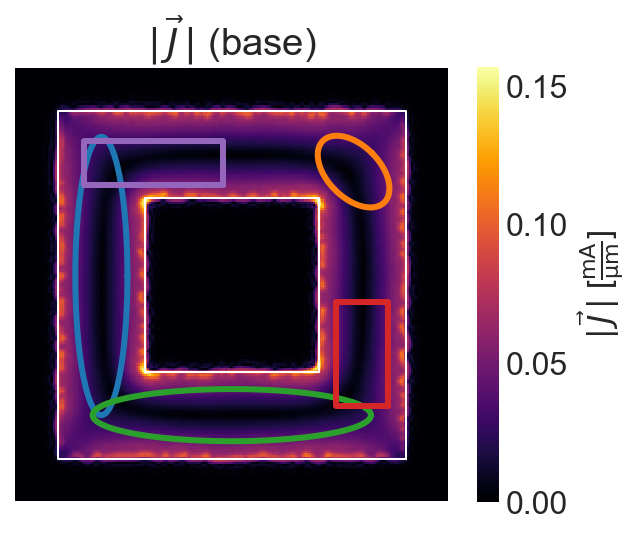

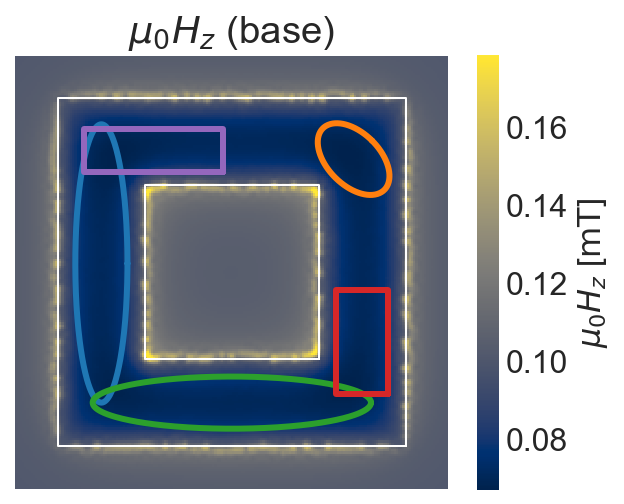

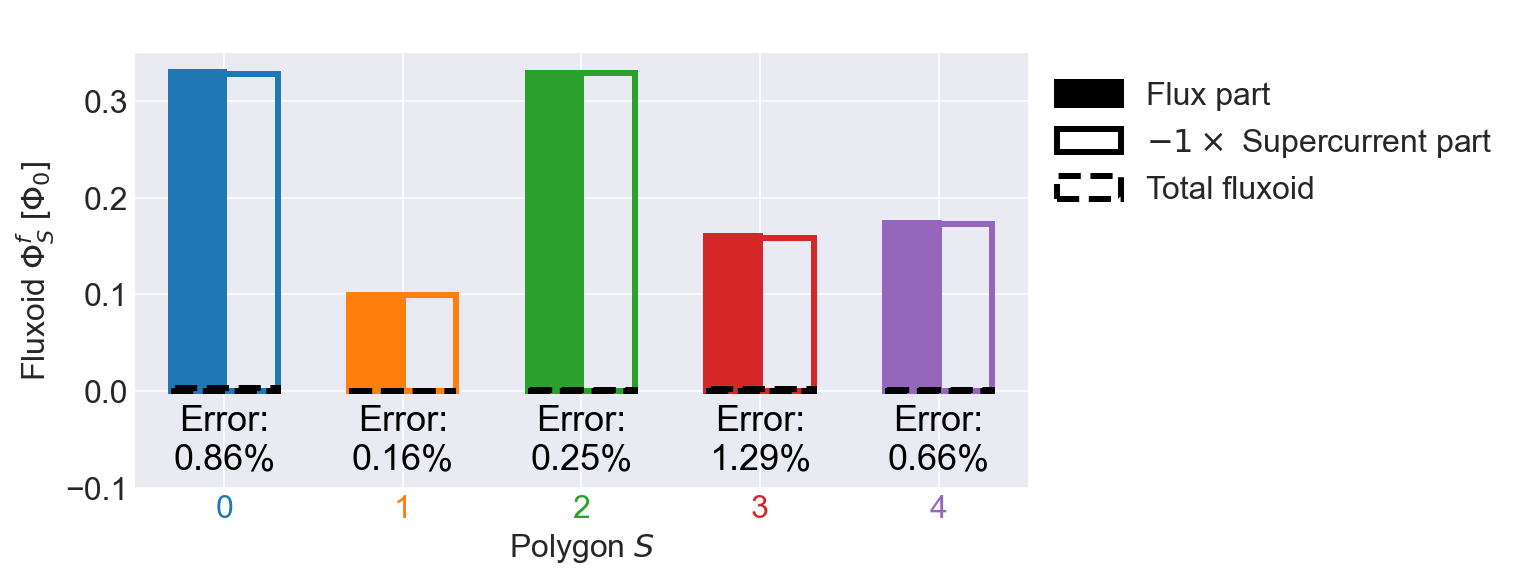

In [16]:
applied_field = sc.sources.ConstantField(0.1)
field_units = "mT"

solution = sc.solve(
    device=square_ring,
    applied_field=applied_field,
    field_units=field_units,
)[-1]


(fig_j, ax_j), (fig_h, ax_h) = plot_polygons(solution, polygons)
fig_f, ax_f, fluxoids = plot_fluxoids(
    solution, polygons, invert_supercurrent_part=True
)

errors = [np.abs(sum(f) / f.flux_part) for f in fluxoids]

ax_f.set_ylim(-0.1, 0.35)
ax_f.set_title(" ")

for i, err in enumerate(errors):
    ax_f.text(i, -0.08, f"Error:\n{100 * err:.2f}%", size=18, color="k", ha="center")
    
if SAVE_FIGURES:
    fig_j.savefig("../images/fluxoid_currents_no_hole.png", dpi=600, bbox_inches="tight")
    fig_h.savefig("../images/fluxoid_fields_no_hole.png", dpi=600, bbox_inches="tight")
    fig_f.savefig("../images/fluxoid_no_hole.png", dpi=600, bbox_inches="tight")
    fluxoid_fnames["Simply-connected region"] = [
        "../images/fluxoid_currents_no_hole.png",
        "../images/fluxoid_fields_no_hole.png",
        "../images/fluxoid_no_hole.png"
    ]

### Simply-connected regions with vortices

INFO:superscreen.solve:Calculating base response to applied field.


0 1 2 3 4 

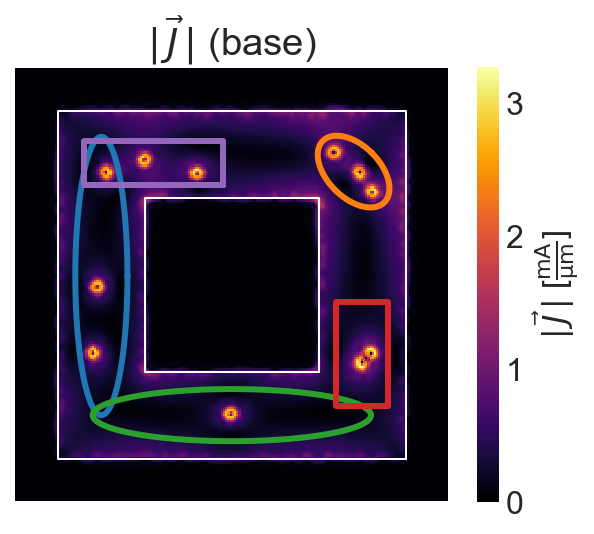

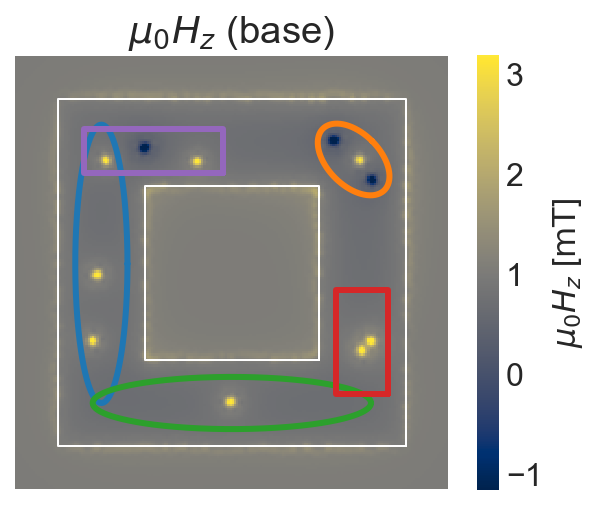

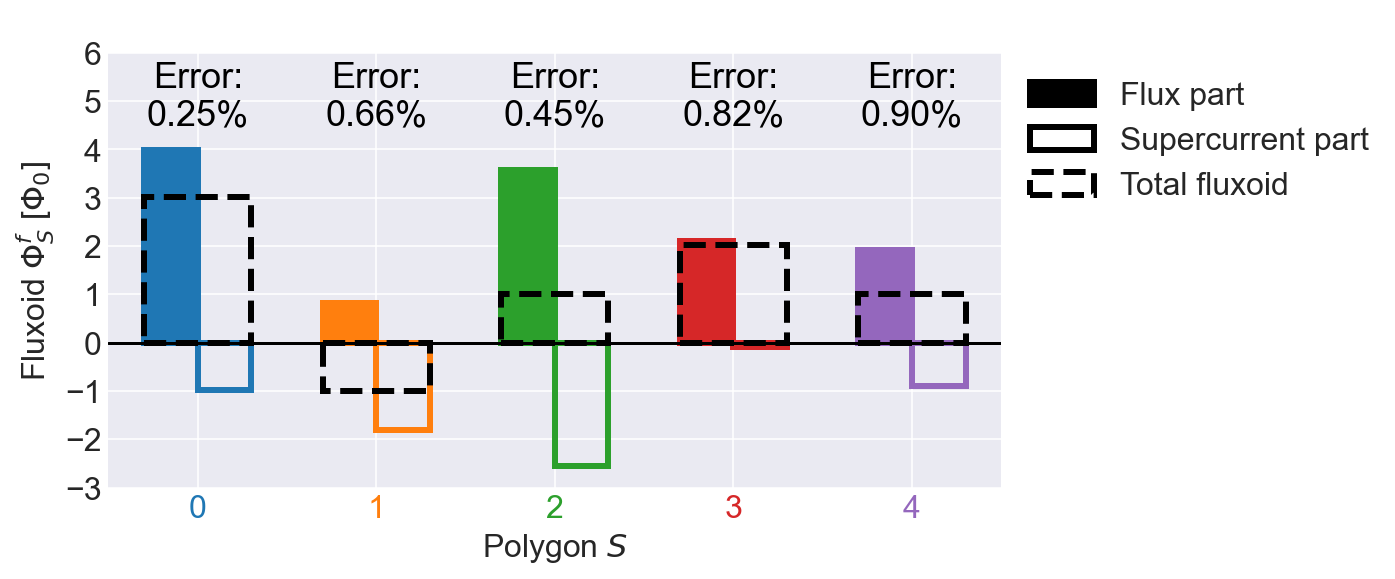

In [17]:
vortices = [
    sc.Vortex(x=4, y=-2, layer="base"),
    sc.Vortex(x=3.75, y=-2.25, layer="base"),
    sc.Vortex(x=0, y=-3.75, layer="base"),
    sc.Vortex(x=3.75, y=3.25, layer="base"),
    sc.Vortex(x=4.0, y=2.75, layer="base", nPhi0=-1),
    sc.Vortex(x=3.0, y=3.75, layer="base", nPhi0=-1),
    sc.Vortex(x=-3.6, y=3.25, layer="base"),
    sc.Vortex(x=-2.5, y=3.5, layer="base", nPhi0=-1),
    sc.Vortex(x=-1, y=3.25, layer="base"),
    sc.Vortex(x=-3.8, y=0, layer="base", nPhi0=1),
    sc.Vortex(x=-4, y=-2, layer="base", nPhi0=1),
]
applied_field = sc.sources.ConstantField(1)
field_units = "mT"

solution = sc.solve(
    device=square_ring,
    applied_field=applied_field,
    field_units=field_units,
    vortices=vortices,
)[-1]

(fig_j, ax_j), (fig_h, ax_h) = plot_polygons(solution, polygons)
fig_f, ax_f, fluxoids = plot_fluxoids(solution, polygons)

expected = np.array([3, -1, 1, 2, 1])
errors = np.abs((np.array([sum(f) for f in fluxoids]) - expected) / expected)

ax_f.set_yticks(range(-3, 7))
ax_f.set_ylim(-3, 6)
ax_f.axhline(0, color="k", ls="-")

for i, err in enumerate(errors):
    ax_f.text(i, 4.5, f"Error:\n{100 * err:.2f}%", size=18, color="k", ha="center")
    
ax_f.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax_f.set_title(" ")
    
if SAVE_FIGURES:
    fig_j.savefig("../images/fluxoid_currents_vortices.png", dpi=600, bbox_inches="tight")
    fig_h.savefig("../images/fluxoid_fields_vortices.png", dpi=600, bbox_inches="tight")
    fig_f.savefig("../images/fluxoid_vortices.png", dpi=600, bbox_inches="tight")
    fluxoid_fnames["Simply-connected region with vortices"] = [
        "../images/fluxoid_currents_vortices.png",
        "../images/fluxoid_fields_vortices.png",
        "../images/fluxoid_vortices.png"
    ]

### Multiply-connect regions

INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.


0 1 2 3 4 5 

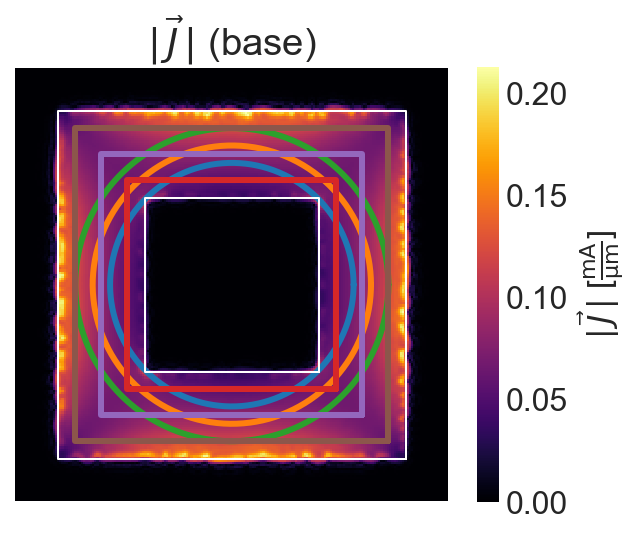

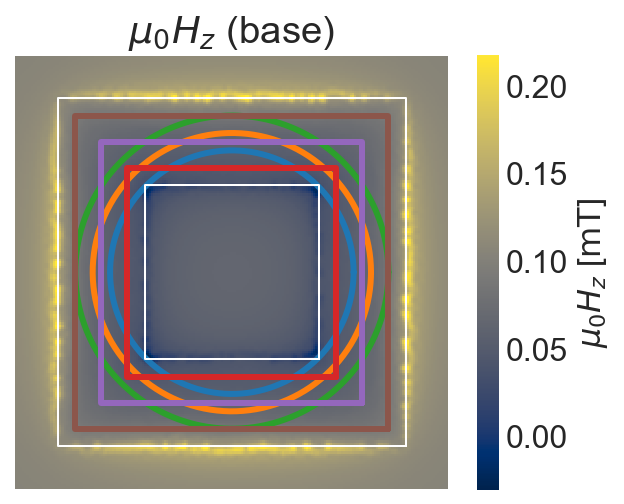

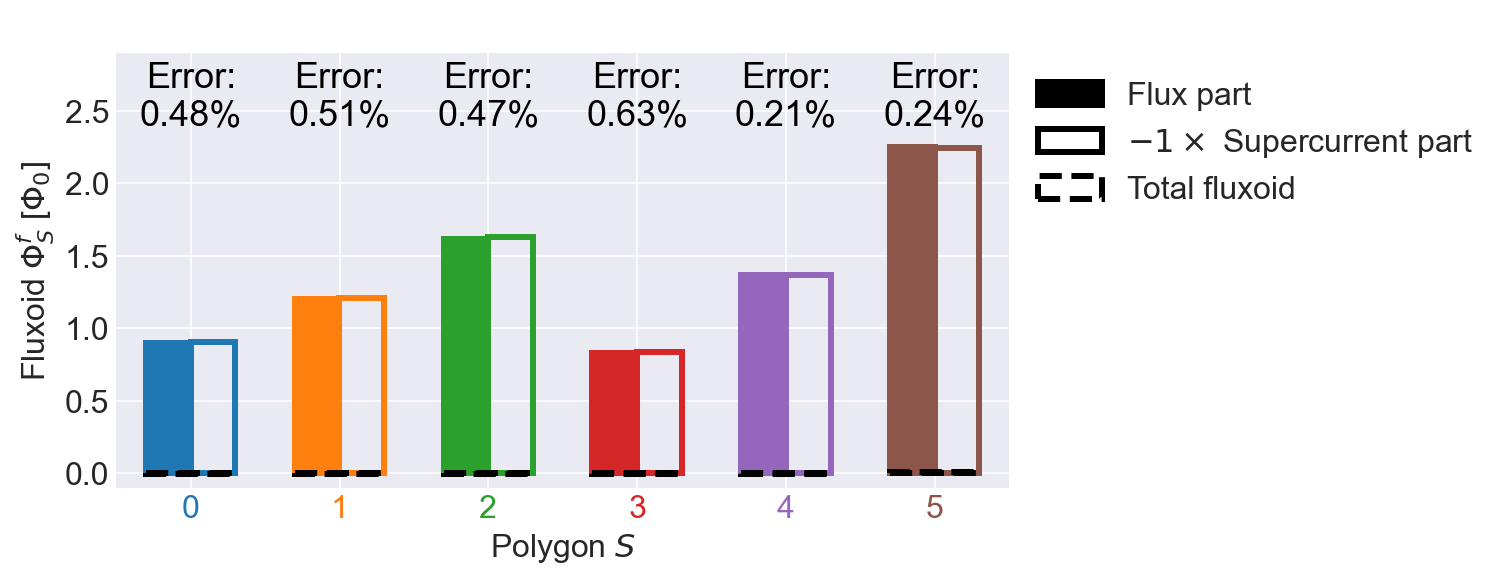

In [18]:
applied_field = sc.sources.ConstantField(0.1)
field_units = "mT"

solution, result = sc.find_fluxoid_solution(
    square_ring,
    hole_polygon_fluxoid_mapping={"hole": (None, 0)},
    applied_field=applied_field,
    field_units=field_units,
)

polygons = []
for r in [3.5, 4.0, 4.5]:
    polygons.append(sc.geometry.circle(r, points=401))
for a in [6, 7.5, 9]:
    polygons.append(sc.geometry.square(a, points_per_side=101))
polygons = [sc.geometry.close_curve(p) for p in polygons]

(fig_j, ax_j), (fig_h, ax_h) = plot_polygons(solution, polygons)

fig_f, ax_f, fluxoids = plot_fluxoids(
    solution, polygons, invert_supercurrent_part=True,
)

errors = [np.abs(sum(f) / f.flux_part) for f in fluxoids]

ax_f.set_ylim(-0.1, 2.9)
ax_f.set_title(" ")

for i, err in enumerate(errors):
    ax_f.text(i, 2.4, f"Error:\n{100 * err:.2f}%", size=18, color="k", ha="center")

if SAVE_FIGURES:
    fig_j.savefig("../images/fluxoid_currents_hole.png", dpi=600, bbox_inches="tight")
    fig_h.savefig("../images/fluxoid_fields_hole.png", dpi=600, bbox_inches="tight")
    fig_f.savefig("../images/fluxoid_hole.png", dpi=600, bbox_inches="tight")
    fluxoid_fnames["Multiply-connected region"] = [
        "../images/fluxoid_currents_hole.png",
        "../images/fluxoid_fields_hole.png",
        "../images/fluxoid_hole.png"
    ]

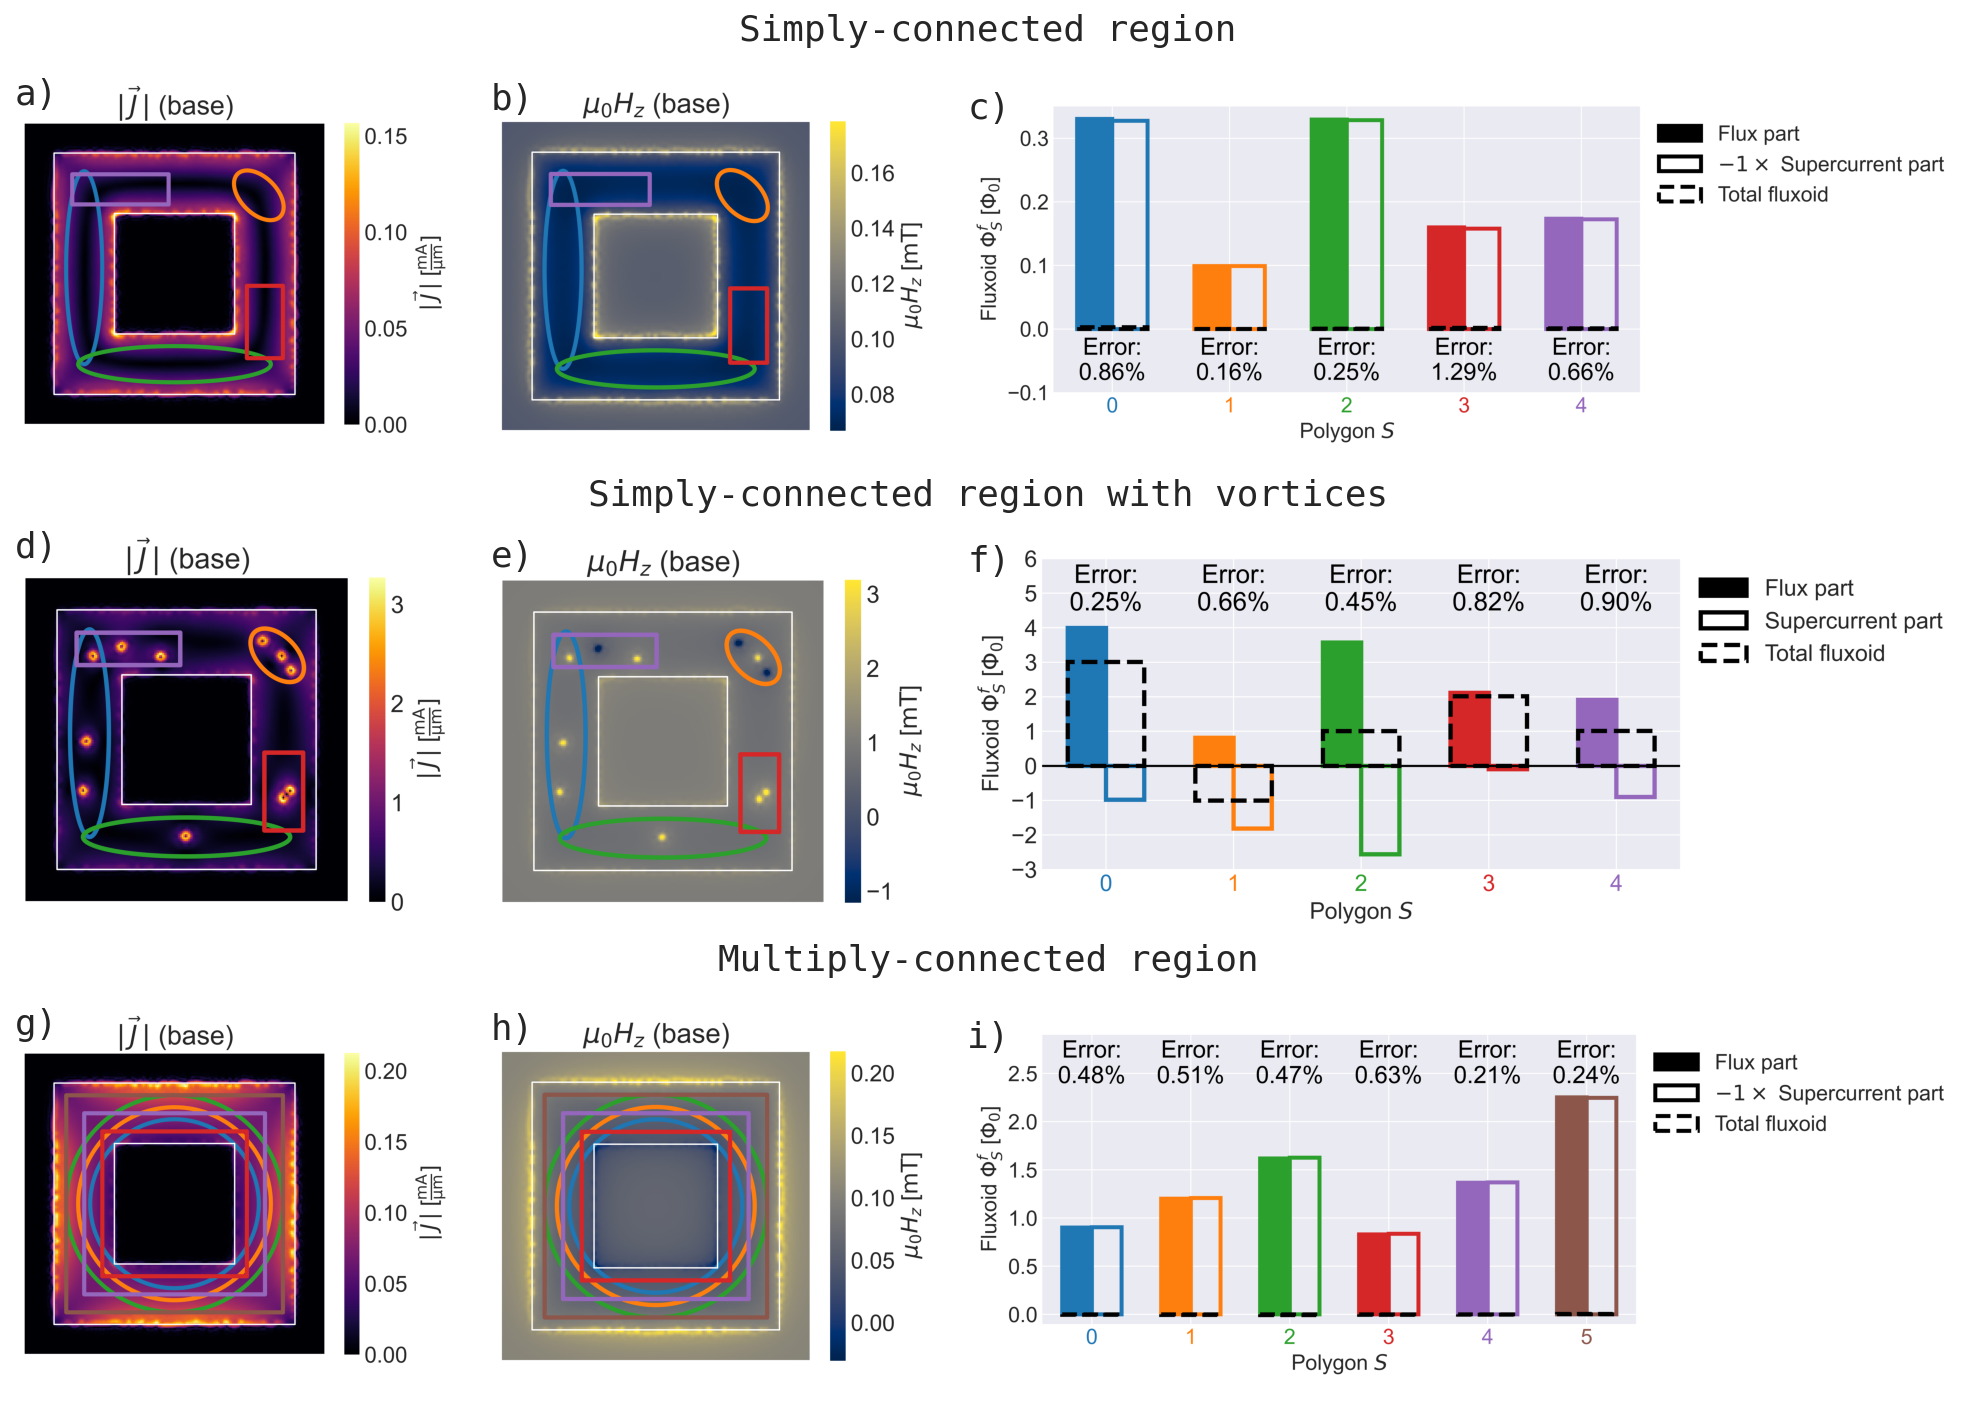

In [19]:
if SAVE_FIGURES:
    fig, fake_axes = plt.subplots(3, 1, figsize=(14, 10), facecolor="w")
    gs = fig.add_gridspec(3, 3, figure=fig, width_ratios=[1, 1, 2.25])
    gs = np.array(list(gs)).reshape(3, 3)
    axes = []

    for gs_row, fake_ax, (title, fnames) in zip(gs, fake_axes, fluxoid_fnames.items()):
        for ax, fn in zip([fig.add_subplot(g) for g in gs_row], fnames):
            ax.imshow(plt.imread(fn))
            ax.axis("off")
            axes.append(ax)
        fake_ax.set_title(title, size=18, family="monospace")
        fake_ax.axis("off")
            
    for i, (ax, label) in enumerate(zip(axes, string.ascii_lowercase)):
        y0 = 0.875 if (i + 1) % 3 == 0 else 0.925
        ax.text(0, y0, label + ")", transform=ax.transAxes, size=18, family="monospace")

    fig.tight_layout()
    
    fig.savefig("../images/fluxoid_combined.png", dpi=600, bbox_inches="tight")